# Sparkify Project Deplpy

In [4]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("seaborn")
sc.install_pypi_package("sklearn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/25/47/22fc373440e144e2111363adaa07abb09ec1f03fbc071b6d9fc0bbf65f68/pandas-1.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/87/a6/8d7d06f6b69236a3c1818157875ceb1259ba0d9df4194f4fe138ffdc0f41/matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5e/c4/6c4fe722df5343c33226f0b4e0bb042e4dc13483228b4718baf286f86d87/certifi-2020.6.20-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9f/b7/4b3304e5fd986e2ad8a0157adba88c01dcefc111deaf84a37175af5f5e43/Pillow-8.0.0-cp37-cp37m-manylinux1_x86_64.whl
  Usin

In [111]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, asc, sum, min, max, split, udf,to_date \
                                , concat_ws,first,last,countDistinct,when,count,datediff,trim,split\
                                , element_at ,row_number,explode, array, lit, create_map
from pyspark.sql.types import StringType,IntegerType,DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer,VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.stat import Correlation
from itertools import chain
import itertools

import re

import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings; 
warnings.simplefilter('ignore')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [139]:
%matplotlib inline

In [49]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1602882177189_0002,pyspark,idle,Link,Link,✔


In [7]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
certifi                    2020.6.20
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     0.16.0   
kiwisolver                 1.2.0    
lxml                       4.5.2    
matplotlib                 3.3.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     1.1.3    
Pillow                     8.0.0    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
scipy                      1.5.2    
s

In [6]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset

In [7]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
#print schema
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [11]:
#data size
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [15]:
#Count distinct users
df.agg(countDistinct("userId")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                 22278|
+----------------------+

In [12]:
#check missing values for each column
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist=5408927, auth=0, firstName=778479, gender=778479, itemInSession=0, lastName=778479, length=5408927, level=0, location=778479, method=0, page=0, registration=778479, sessionId=0, song=5408927, status=0, ts=0, userAgent=778479, userId=0)]

In [16]:
#explore users with missing user id
df.filter(df.userId == "").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [22]:
#explore users who are either logged out or guests (778479/26259199 = 3% records)
df.filter((df.auth == "Logged Out")|(df.auth == "Guest")).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

778479

In [23]:
#explore users who are either logged out or guests (they share the same userID)
df.filter((df.auth == "Logged Out")|(df.auth == "Guest")).agg(countDistinct("userId")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                     1|
+----------------------+

In [14]:
#explore users with missing sessionId
df.filter(df.sessionId == "").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [8]:
#exclude logged out users or Guests
df_valid = df.filter((df.auth != "Logged Out")&(df.auth != "Guest"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Feature Engineering

### Define Churn

In [9]:
#flag Cancellation Confirmation event
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_valid = df_valid.withColumn("Cancellation", flag_cancel_event("page"))
df_valid.filter(df_valid.page =='Cancellation Confirmation').head()
#define Churn users
windowval = Window.partitionBy("userId")
df_valid = df_valid.withColumn("Churn", max("Cancellation").over(windowval))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Extract Features

In [10]:
#add date time
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_valid = df_valid.withColumn("year",get_year("ts"))
df_valid = df_valid.withColumn("month",get_month("ts"))
df_valid = df_valid.withColumn("day",get_day("ts"))
df_valid = df_valid.withColumn("hour",get_hour("ts"))
df_valid = df_valid.withColumn("date", to_date(concat_ws("-", "year", "month", "day")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
#check last data and first date 
df_valid.agg(max(col('date')),min(col('date'))).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+
| max(date)| min(date)|
+----------+----------+
|2018-12-01|2018-10-01|
+----------+----------+

In [13]:
# main state (highest frequency)
df_valid = df_valid.withColumn("state", trim(element_at(split(col("location"), ","),-1)))
state_cnt = df_valid.groupBy("userId", "state").count()

w = Window().partitionBy("userId").orderBy(col("count").desc())

main_state = (state_cnt
  .withColumn("rn", row_number().over(w))
  .where(col("rn") == 1)
  .select("userId", col("state").alias('main_state')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Adding main state feature to df_valid
df_valid = df_valid.join(main_state, on = 'userId')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Extract potential features 
df_user = df_valid.groupby('userId').agg(
     # target
     first(col('Churn')).alias('label'),
     # gender
     first(when(col('gender') == "F", 1).otherwise(0)).alias('female'),
     # #main state ratio
     #((sum(when(col('state') == col('main_state'), 1).otherwise(0)))/count(col('state'))).alias("mstate_ratio"),
     # distinct locations
     #countDistinct(col('location')).alias('ulocation_ct'),
     # distinct page actions
     countDistinct(col('page')).alias('upage_ct'),
     # page action ratio
    ((sum(when(col('page') == "Thumbs Up", 1).otherwise(0)))/count(col('page'))).alias("tbup_ratio"),
    ((sum(when(col('page') == "Thumbs Down", 1).otherwise(0)))/count(col('page'))).alias("tbdw_ratio"),
    ((sum(when(col('page') == "Add Friend", 1).otherwise(0)))/count(col('page'))).alias("addfriend_ratio"),   
    ((sum(when(col('page') == "Roll Advert", 1).otherwise(0)))/count(col('page'))).alias("ad_ratio"),
    ((sum(when(col('page') == "Upgrade", 1).otherwise(0)))/count(col('page'))).alias("up_ratio"),
    ((sum(when(col('page') == "Help", 1).otherwise(0)))/count(col('page'))).alias("help_ratio"),
    ((sum(when(col('page') == "Error", 1).otherwise(0)))/count(col('page'))).alias("error_ratio"),
     # enroll days
     (datediff(max(col('date')),min(col('date'))) +1).alias("enroll_days"),
     # active days
     countDistinct(col('date')).alias('active_days'),
     # active ratio
     (countDistinct(col('date'))/(datediff(max(col('date')),min(col('date'))) +1)).alias('active_ratio'),
     # distinct artists per active day 
     (countDistinct(col('artist'))/countDistinct(col('date'))).alias('uartist_pact'),
     # distinct songs per active day
     (countDistinct(col('song'))/countDistinct(col('date'))).alias('usong_pact'),
     # avg songs per active day 
     (sum(when(col('page') == "NextSong",1).otherwise(0))/countDistinct(col('date'))).alias("tsong_pact"),
     # avg items per session
     (count(col('itemInSession'))/countDistinct(col('sessionId'))).alias("item_pses"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#check user example
df_user.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(userId='1076191', label=1, female=0, mstate_ratio=1.0, ulocation_ct=1, upage_ct=9, tbup_ratio=0.0625, tbdw_ratio=0.015625, addfriend_ratio=0.0, ad_ratio=0.078125, up_ratio=0.0, help_ratio=0.0, error_ratio=0.0, enroll_days=9, active_days=3, active_ratio=0.3333333333333333, uartist_pact=15.666666666666666, usong_pact=15.666666666666666, tsong_pact=15.666666666666666, item_pses=21.333333333333332)

### Explore Features

In [32]:
#print schema
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- female: integer (nullable = true)
 |-- mstate_ratio: double (nullable = true)
 |-- ulocation_ct: long (nullable = false)
 |-- upage_ct: long (nullable = false)
 |-- tbup_ratio: double (nullable = true)
 |-- tbdw_ratio: double (nullable = true)
 |-- addfriend_ratio: double (nullable = true)
 |-- ad_ratio: double (nullable = true)
 |-- up_ratio: double (nullable = true)
 |-- help_ratio: double (nullable = true)
 |-- error_ratio: double (nullable = true)
 |-- enroll_days: integer (nullable = true)
 |-- active_days: long (nullable = false)
 |-- active_ratio: double (nullable = true)
 |-- uartist_pact: double (nullable = true)
 |-- usong_pact: double (nullable = true)
 |-- tsong_pact: double (nullable = true)
 |-- item_pses: double (nullable = true)

##### #target measure plots 

In [16]:
#prepare target data
target_df = df_user.groupby('label').count()
target_pdf = target_df.toPandas()
target_pdf['label'] = target_pdf['label'].astype('category')
target_pdf['Percent'] = target_pdf['count']/target_pdf['count'].sum() 
target_pdf

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  label  count   Percent
0     1   5003  0.224581
1     0  17274  0.775419

In [29]:
#target plot
churn_pt = target_pdf.plot(kind ='bar',x ='label',y='Percent',legend = None,color ='navy', \
            title = 'Churn Distribution (Full 12GB Dataset)',xlabel = '', ylabel ='Percent', figsize = (8,5));
for p in churn_pt.patches:
    txt = str(p.get_height().round(2)* 100) + '%'
    txt_x = p.get_x() + p.get_width() / 2.6
    txt_y = p.get_height()+0.01
    churn_pt.text(txt_x,txt_y,txt)
#plt.savefig('s3://aws-emr-resources-631922983932-us-east-2/e-C01H7UNHA5J04BSQL7GOJGG6X/churn.png')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(-0.05769230769230771, 0.23458140683215875, '22.0%')
Text(0.9423076923076923, 0.7854185931678412, '78.0%')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

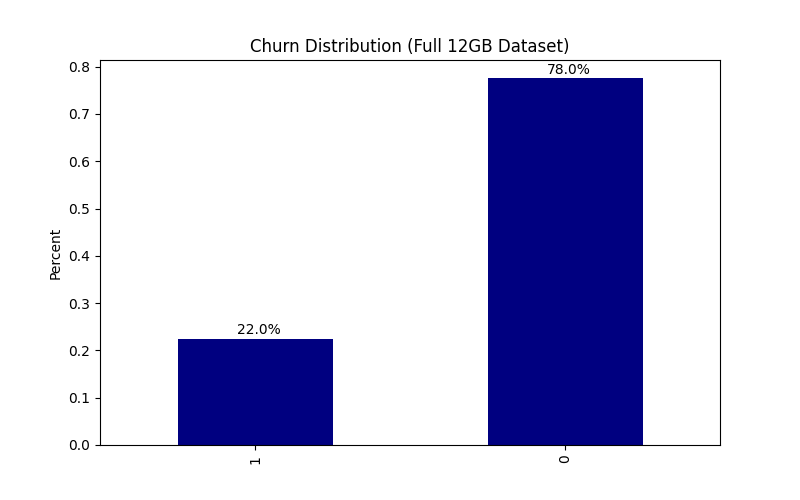

In [30]:
%matplot plt

In [ ]:
#img_data = io.BytesIO()
#plt.savefig(img_data, format='png')
#img_data.seek(0)

#####  fields with only one distinct value

In [35]:
# countDistinct value for each column
expr = [countDistinct(c).alias(c) for c in df_user.columns]

# apply those functions
countdf =  df_user.select(*expr)
countdf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+------+------------+------------+--------+----------+----------+---------------+--------+--------+----------+-----------+-----------+-----------+------------+------------+----------+----------+---------+
|userId|label|female|mstate_ratio|ulocation_ct|upage_ct|tbup_ratio|tbdw_ratio|addfriend_ratio|ad_ratio|up_ratio|help_ratio|error_ratio|enroll_days|active_days|active_ratio|uartist_pact|usong_pact|tsong_pact|item_pses|
+------+-----+------+------------+------------+--------+----------+----------+---------------+--------+--------+----------+-----------+-----------+-----------+------------+------------+----------+----------+---------+
| 22277|    2|     2|           1|           1|      19|     11880|      9465|          10383|   12897|    7078|      7913|       5304|         61|         61|         958|        8394|      9220|      9563|    10456|
+------+-----+------+------------+------------+--------+----------+----------+---------------+--------+--------+----------+-----

In [37]:
# extract the columns which have just one value
one_value_to_drop = [k for k,v in countdf.collect()[0].asDict().items() if v == 1]
one_value_to_drop

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['mstate_ratio', 'ulocation_ct']

##### fields with high correlation

In [38]:
#numeric variables
num_vector = list(set(df_user.columns)-set(['userId','female'])-set(one_value_to_drop))
num_vector

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['error_ratio', 'usong_pact', 'upage_ct', 'addfriend_ratio', 'active_days', 'enroll_days', 'item_pses', 'tbdw_ratio', 'up_ratio', 'ad_ratio', 'active_ratio', 'uartist_pact', 'tsong_pact', 'label', 'help_ratio', 'tbup_ratio']

In [39]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_user.select(num_vector).columns, outputCol=vector_col)
df_vector = assembler.transform(df_user.select(num_vector)).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
#matrix head name
head = df_user.select(num_vector).columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
#correlation matrix
corr = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(16,16))
corr.columns = head
corr.index = head
corr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                 error_ratio  usong_pact  ...  help_ratio  tbup_ratio
error_ratio         1.000000   -0.017840  ...   -0.014701   -0.040267
usong_pact         -0.017840    1.000000  ...   -0.010930    0.101100
upage_ct            0.040470    0.534562  ...    0.066610    0.075630
addfriend_ratio    -0.013183   -0.014889  ...    0.028843   -0.069015
active_days        -0.013901    0.304876  ...    0.007492    0.118906
enroll_days        -0.017652    0.080075  ...    0.030309    0.130688
item_pses          -0.014321    0.904392  ...   -0.007082    0.089550
tbdw_ratio         -0.006346   -0.082510  ...   -0.004458   -0.100777
up_ratio           -0.009756   -0.302070  ...   -0.003553   -0.072787
ad_ratio            0.006918   -0.526481  ...   -0.010654   -0.280387
active_ratio        0.009217    0.223136  ...   -0.039895   -0.039150
uartist_pact       -0.016764    0.972071  ...   -0.012758    0.088603
tsong_pact         -0.018012    0.992287  ...   -0.010030    0.104174
label              -

In [42]:
# Creating ABS correlation matrix
corr_abs = corr.abs()
# Selecting upper triangle of correlation matrix
upper_tri = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(np.bool))
# Finding feature columns with correlation greater than 0.95
high_cor_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
high_cor_to_drop

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['uartist_pact', 'tsong_pact']

##### drop fields from two lists above

In [43]:
# transfer the drop list to spark data frame
drop_list = one_value_to_drop + high_cor_to_drop
drop_list 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['mstate_ratio', 'ulocation_ct', 'uartist_pact', 'tsong_pact']

In [12]:
#drop_list = ['uartist_pact', 'tsong_pact']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
#drop fields from drop list
df_user_clean = df_user.drop(*drop_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
#check final data frame
df_user_clean.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['userId', 'label', 'female', 'upage_ct', 'tbup_ratio', 'tbdw_ratio', 'addfriend_ratio', 'ad_ratio', 'up_ratio', 'help_ratio', 'error_ratio', 'enroll_days', 'active_days', 'active_ratio', 'usong_pact', 'item_pses']

# Modelling and Evaluation

### Step 1. Split the full dataset into train (cross-validation) and test sets. 

In [14]:
#split the data
train, test = df_user_clean.randomSplit([0.7, 0.3], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
#check churn distribution
train.groupby('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1| 3448|
|    0|12128|
+-----+-----+

### Step 2. Build machine learning Pipeline.

In [15]:
#create initial machine learning pielines
def initial_model(numcols,catcols,classifier = LogisticRegression(maxIter=10),train = train, test = test):
    '''
    INPUT:
    numcols - numerical columns
    catcols - categorical columns (binary)
    classifier - machine learning classifier model
    train - train data
    test - test data
    
    OUTPUT:
    pipeline - machine learning pipeline
    Model - fitted model based on train data
    prediction - predictions on test data
    run time in mins
    '''
    
    start = time.time()
    # Combining into VectorAssembler
    num_assembler = VectorAssembler(inputCols = numcols, outputCol = "num_vector")
    # Standardizing numerical features
    scaler = StandardScaler(inputCol = "num_vector", outputCol = "num_scaled", withStd = True, withMean = True)

    # Add binary feature (do not scale)
    total_assembler = VectorAssembler(inputCols = catcols + ["num_scaled"], outputCol = "features")

    # choose classifiers
    ml =  classifier
    pipeline = Pipeline(stages = [num_assembler, scaler, total_assembler, ml])
    Model = pipeline.fit(train)
    prediction = Model.transform(test) 
    
    end = time.time()
    
    return pipeline,Model, prediction,round(round(end-start)/60,2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
#evaluation function
def evaluation(prediction):
    '''
    INPUT:
    prediction - predictions on test data
    
    OUTPUT:
    accuracy - metric: (TP + TN)/(TP + TN + FP + FN)
    F1 score - metric: 2 * (Recall * Precision) / (Recall + Precision)
    '''
    
    # Input: model prediction results
    # Output: accuracy and F1 score
       # accuracy: (TP + TN)/(TP + TN + FP + FN)
       # precision: TP/(TP + FP)
       # recall: TP/(TP + FN)
       # f1 score: 2*(Recall * Precision) / (Recall + Precision)
  
    # Combine prediction and labels
    predictionAndLabels = prediction.select(['prediction','label']) \
                      .withColumn("label",col("label").cast(DoubleType())).rdd

    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Overall statistics
    accuracy = metrics.accuracy
    precision = metrics.precision(label =1.0)
    recall = metrics.recall(label =1.0)
    f1Score = metrics.fMeasure(label =1.0)
    print("Summary Stats")
    print("Accuracy = %s" % accuracy)
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
       
    return round(accuracy,3),round(f1Score,3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
#final features used in the model
numcols = list(set(df_user_clean.columns)-set(['userId','female','label']))
catcols = ['female']
numcols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['error_ratio', 'usong_pact', 'upage_ct', 'addfriend_ratio', 'item_pses', 'active_days', 'enroll_days', 'tbdw_ratio', 'up_ratio', 'ad_ratio', 'active_ratio', 'help_ratio', 'tbup_ratio']

#### Logistic Regression

In [55]:
# Create logistic regression classifier
pipeline_lr, model_lr, prediction_lr, time_lr = initial_model(numcols,catcols, \
                                                              LogisticRegression(maxIter=10),train, test)
print('Logistic Regression Run time (mins): ',time_lr)
acc_lr, f1_lr = evaluation(prediction_lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Run time (mins):  5.52
Summary Stats
Accuracy = 0.9195642441426652
Precision = 0.8724340175953079
Recall = 0.7652733118971061
F1 Score = 0.8153477218225419

#### Random Forest

In [58]:
# Create Random Forest classifier 
pipeline_rf, model_rf, prediction_rf, time_rf = initial_model(numcols,catcols, \
                                                              RandomForestClassifier(),train, test)
print('Random Forest Run time (mins): ',time_rf)
acc_rf, f1_rf = evaluation(prediction_rf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest Run time (mins):  17.15
Summary Stats
Accuracy = 0.9068795702134009
Precision = 0.9251141552511416
Recall = 0.6514469453376206
F1 Score = 0.7645283018867925

#### Gradient-boosted Tree

In [43]:
# Create Gradient-boosted tree classifier 
pipeline_gbt, model_gbt, prediction_gbt, time_gbt = initial_model(numcols,catcols, \
                                                                  GBTClassifier(maxIter=10),train, test)
print('Gradient-boosted Tree Run time (mins): ',time_gbt)
acc_gbt, f1_gbt = evaluation(prediction_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient-boosted Tree Run time (mins):  6.02
Summary Stats
Accuracy = 0.933293538277869
Precision = 0.9314641744548287
Recall = 0.7691318327974277
F1 Score = 0.8425501937301867

#### Linear Support Vector Machine

In [64]:
# Create Linear Support Vector Machine classifier 
pipeline_svc, model_svc, prediction_svc, time_svc = initial_model(numcols,catcols, \
                                                                  LinearSVC(maxIter=10),train, test)
print('Linear Support Vector Machine Run time (mins): ',time_svc) 
acc_svc, f1_svc = evaluation(prediction_svc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Linear Support Vector Machine Run time (mins):  14.88
Summary Stats
Accuracy = 0.9185196239367258
Precision = 0.8859984697781178
Recall = 0.7446945337620579
F1 Score = 0.8092243186582809

#### Initial Models Performance Summary

In [65]:
# Model Performance summary for initial models
print('Performance Summary for initial models\n')
print("Logistic Regression model results: F1 Score {}, Accuracy is {}".format(f1_lr, acc_lr))
print("Random Forest model results: F1 Score {}, Accuracy is {}".format(f1_rf, acc_rf))
print("Gradient-boosted Tree model results: F1 Score {}, Accuracy is {}".format(f1_gbt, acc_gbt))
print("Linear Support Vector Machine results: F1 Score {}, Accuracy is {}".format(f1_svc, acc_svc))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Performance Summary for initial models

Logistic Regression model results: F1 Score 0.815, Accuracy is 0.92
Random Forest model results: F1 Score 0.765, Accuracy is 0.907
Gradient-boosted Tree model results: F1 Score 0.843, Accuracy is 0.933
Linear Support Vector Machine results: F1 Score 0.809, Accuracy is 0.919

### Step 3. Implement three methods to treat imbalanced class issue.

The data have imblanced classes issue. So I try 3 different methods below to handle this.
1. Oversampling
2. Undersampling
3. Balancing class weights

#### Stratified split dataframes 

In [18]:
# seperate minority/majority data
label1_full = df_user_clean.filter(df_user_clean.label == 1)
label0_full = df_user_clean.filter(df_user_clean.label == 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# calculate unbalanced ratio
#ratio = label0_full.count()/ label1_full.count()
#ratio

In [20]:
# split datasets into training and testing
train0, test0 = label0_full.randomSplit([0.7,0.3], seed=42)
train1, test1 = label1_full.randomSplit([0.7,0.3], seed=42)
# stack datasets back together
train_stra = train0.union(train1)
test_stra = test0.union(test1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# seperate minority/majority on training data
label1_df = train_stra.filter(train_stra.label == 1)
label0_df = train_stra.filter(train_stra.label == 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
#sample size before oversampling 
y = train_stra.groupby('label').count().collect()
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(label=1, count=3495), Row(label=0, count=12068)]

In [32]:
# calculate unbalanced ratio
ratio = y[1][1]/ y[0][1]
ratio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3.4529327610872675

#### 1. Oversampling

In [33]:
# duplicate the minority data (label1)
label1_os = label1_df.withColumn("dummy", explode(array([lit(x) for x in range(int(ratio))]))).drop('dummy')
# combine both oversampled minority label 1 and previous majority label 0
combined_os_df = label0_df.unionAll(label1_os)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
# Create logistic regression classifier
pipeline_lr_os, model_lr_os, prediction_lr_os, time_lr_os = initial_model(numcols,catcols, \
                                                              LogisticRegression(maxIter=10), \
                                                              combined_os_df, test_stra)
print('Logistic Regression Run time (mins): ',time_lr_os)
acc_lr_os, f1_lr_os = evaluation(prediction_lr_os)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Run time (mins):  5.97
Summary Stats
Accuracy = 0.9070598748882931
Precision = 0.7517084282460137
Recall = 0.8753315649867374
F1 Score = 0.8088235294117646

In [35]:
# Create Gradient-boosted tree classifier
pipeline_gbt_os, model_gbt_os, prediction_gbt_os, time_gbt_os = initial_model(numcols,catcols, \
                                                              GBTClassifier(maxIter=10), \
                                                              combined_os_df, test_stra)
print('Gradient-boosted tree Run time (mins): ',time_gbt_os)
acc_gbt_os, f1_gbt_os = evaluation(prediction_gbt_os)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient-boosted tree Run time (mins):  6.37
Summary Stats
Accuracy = 0.9139112302651177
Precision = 0.7600671140939598
Recall = 0.9011936339522546
F1 Score = 0.8246359223300971

#### 2. Undersampling

In [37]:
#random delete some records from majority label 0
label0_us  = label0_df.sample(False, 1/ratio)
# combine both undersampled majority label 0 and previous minority label 1
combined_us_df = label1_df.unionAll(label0_us)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#sample size after undersampling 
combined_us_df.groupby('label').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1| 3469|
|    0| 3529|
+-----+-----+

In [34]:
# Create logistic regression classifier
pipeline_lr_us, model_lr_us, prediction_lr_us, time_lr_us = initial_model(numcols,catcols, \
                                                              LogisticRegression(maxIter=10), \
                                                              combined_us_df, test_stra)
print('Logistic Regression Run time (mins): ',time_lr_us)
acc_lr_us, f1_lr_us = evaluation(prediction_lr_us)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Run time (mins):  15.77
Summary Stats
Accuracy = 0.8985701519213584
Precision = 0.7250952640174197
Recall = 0.883289124668435
F1 Score = 0.7964125560538118

In [38]:
# Create Gradient-boosted tree classifier
pipeline_gbt_us, model_gbt_us, prediction_gbt_us, time_gbt_us = initial_model(numcols,catcols, \
                                                              GBTClassifier(maxIter=10), \
                                                              combined_us_df, test_stra)
print('Gradient-boosted tree Run time (mins): ',time_gbt_us)
acc_gbt_us, f1_gbt_us = evaluation(prediction_gbt_us)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient-boosted tree Run time (mins):  7.1
Summary Stats
Accuracy = 0.9100387250521299
Precision = 0.7475355969331873
Recall = 0.9051724137931034
F1 Score = 0.8188362327534494

#### 3. Balancing class weights

In [ ]:
#calculate class weights in pandas data frame
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# class weight: n_samples / (n_classes * np.bincount(y)).

In [35]:
#calculate class weights in spark data frame
y = train_stra.groupby('label').count().collect()
unique_y = [x["label"] for x in y]
total_y = train_stra.count()
unique_y_count = len(unique_y)
bin_count = [x["count"] for x in y]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{1: 2.2264663805436338, 0: 0.644804441498177}

In [36]:
#create a mapping to apply a weight to each training instance.
mapping_weight = create_map([lit(x) for x in chain(*class_weights_spark.items())])
train_stra_weight = train_stra.withColumn("weight", mapping_weight.getItem(col("label")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
# Create logistic regression classifier
pipeline_lr_wc, model_lr_wc, prediction_lr_wc, time_lr_wc = initial_model(numcols,catcols, \
                                                              LogisticRegression(maxIter=10,weightCol="weight"), \
                                                              train_stra_weight, test_stra)
print('Logistic Regression Run time (mins): ',time_lr_wc)
acc_lr_wc, f1_lr_wc = evaluation(prediction_lr_wc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression Run time (mins):  9.15
Summary Stats
Accuracy = 0.8994638069705094
Precision = 0.7279693486590039
Recall = 0.8819628647214854
F1 Score = 0.7976011994002998

#### Fixing Imbalanced Classes Performance Summary

In [ ]:
# Model Performance summary for fixing imbalanced classes
print('Performance Summary for Fixing Imbalanced Classes\n')
print('Logistic Regression model')
print("Initial Logistic Regression model results: F1 Score {}, Accuracy is {}".format(f1_lr, acc_lr))
print("1. Oversampling: F1 Score {}, Accuracy is {}".format(f1_lr_os, acc_lr_os))
print("2. Undersampling: F1 Score {}, Accuracy is {}".format(f1_lr_us, acc_lr_us))
print("3. Balancing class weights: F1 Score {}, Accuracy is {}".format(f1_lr_wc, acc_lr_wc))

In [62]:
# Model Performance summary for fixing imbalanced classes
print('Gradient-boosted Tree model')
print("Initial Gradient-boosted Tree model results: F1 Score {}, Accuracy is {}".format(f1_gbt, acc_gbt))
print("1. Oversampling: F1 Score {}, Accuracy is {}".format(f1_gbt_os, acc_gbt_os))
print("2. Undersampling: F1 Score {}, Accuracy is {}".format(f1_gbt_us, acc_gbt_us))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient-boosted Tree model
Initial Gradient-boosted Tree model results: F1 Score 0.843, Accuracy is 0.933
1. Oversampling: F1 Score 0.825, Accuracy is 0.914
2. Undersampling: F1 Score 0.819, Accuracy is 0.91

### Step 4. Conduct 3-fold cross validation and tune parameters. 

In [39]:
# tune models
def model_tuning(pipeline,paramGrid,train = train, test = test):
    '''
    INPUT:
    pipeline - machine learning pipeline
    paramGrid - parameter grid for grid search
    train - train data
    test - test data
    
    OUTPUT:
    Model - fitted model based on train data
    prediction - predictions on test data
    run time in mins
    '''
    start = time.time()
    # Combining into VectorAssembler
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
    cvmodel = crossval.fit(train)
    #predict on test data
    cvprediction = cvmodel.transform(test)
    end = time.time()
    
    return cvmodel, cvprediction,round(round(end-start)/60,2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
# check grid search results 
def cvmodel_result(cvmodel):
    '''
    INPUT:
    Model - fitted model based on train data
    
    OUTPUT:
    p_df - pandas data frame of grid search results
    '''
    f1 = cvmodel.avgMetrics
    p_df = pd.DataFrame({p.name: v for p, v in param.items()} for param in cvmodel.getEstimatorParamMaps())
    p_df['f1'] = f1
    p_df = p_df.sort_values(by ='f1',ascending =False)
    
    return p_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
#feature importance
def feature_importance(cvmodel,metric):
    '''
    INPUT:
    Model - fitted model based on train data
    
    OUTPUT:
    f_df - pandas data frame of feature metric (importance)
    '''
    f_df = pd.DataFrame()
    feature = catcols + numcols
    f_df['feature'] = feature
    f_df['importance'] = metric 
    f_df = f_df.sort_values(by ='importance',ascending =False)

    return f_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [170]:
#plot confusion matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    INPUT:
    cm - confusion matrix
    classes - classes list
    normalize - Normalization
    title - plot title
    cmap - plot color pattern
    
    OUTPUT:
    print and plot the confusion matrix
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Logistic Regression Tuning
 - maxIter (maximum number of iterations, default=100): [10, 30]
 - threshold (Threshold in binary classification prediction, default = 0.5):[0.4, 0.5]

In [56]:
# Extract the summary from the returned LogisticRegressionModel instance trained (undersampling)
trainingSummary = model_lr.stages[-1].summary
# check the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
bestThreshold

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.40813926905070297

In [57]:
# parameter grid: maxIter,threshold.
paramGrid_lr = ParamGridBuilder() \
    .addGrid(model_lr.stages[-1].maxIter,[10, 30]) \
    .addGrid(model_lr.stages[-1].threshold,[0.4,0.5]) \
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-53:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8864



In [58]:
# tune the model (apply undersampling)
cvmodel_lr, cvprediction_lr, cvtime_lr = model_tuning(pipeline_lr,paramGrid_lr,train, test)
print('Logistic Regression Model Tuning time (mins): ',cvtime_lr)
cvacc_lr, cvf1_lr = evaluation(cvprediction_lr)
# F1 score on test data even decrease compared to the initial model. (overfitting on training data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-54:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8897



Logistic Regression Model Tuning time (mins):  12.95
Summary Stats
Accuracy = 0.9206088643486047
Precision = 0.8367346938775511
Recall = 0.817363344051447
F1 Score = 0.8269355888093689

In [59]:
# training model results
cvmodel_result(cvmodel_lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   maxIter  threshold        f1
0       10        0.4  0.919546
2       30        0.4  0.918898
1       10        0.5  0.918354
3       30        0.5  0.918292

In [60]:
# Coefficients
lr_imp = feature_importance(cvmodel_lr,cvmodel_lr.bestModel.stages[-1].coefficients)
lr_imp['odds'] = np.exp(lr_imp['importance'])
lr_imp.plot(kind ='barh',x ='feature',y='importance',color ='navy',legend=None,\
            title = 'Logistic Regression Coefficients (Full 12GB Dataset)',figsize = (8,5)).invert_yaxis();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-56:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 10695



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

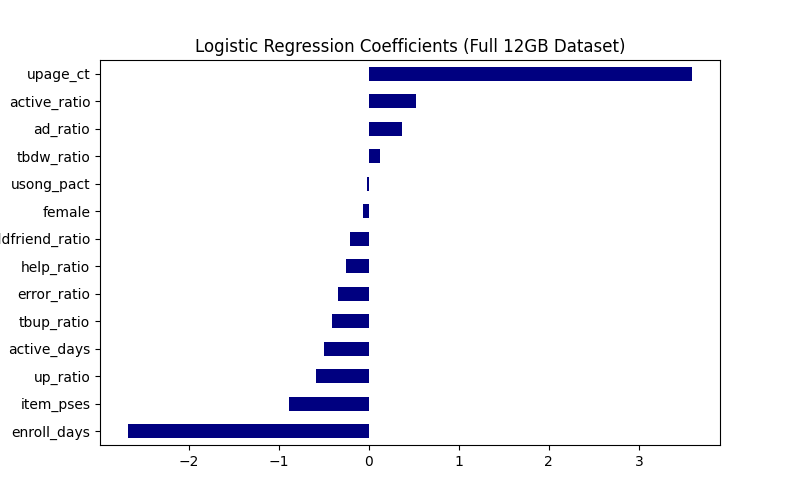

In [61]:
%matplot plt

In [ ]:
#plot confusion_matrix class names
class_names = cvprediction_gbt.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_names["label"].values.tolist()
class_names

In [165]:
#plot confusion_matrix
y_truelr = cvprediction_lr.select("label").withColumn("label",col("label").cast(DoubleType()))
y_truelr = y_truelr.toPandas()
y_predlr = cvprediction_lr.select("prediction")
y_predlr = y_predlr.toPandas()

cnf_matrix_lr = confusion_matrix(y_truelr, y_predlr)
cnf_matrix_lr

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[4898,  248],
       [ 284, 1271]])

In [166]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8,5))
cm_lr = plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Logistic Regression Confusion matrix\nwithout normalization')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix, without normalization
[[4898  248]
 [ 284 1271]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

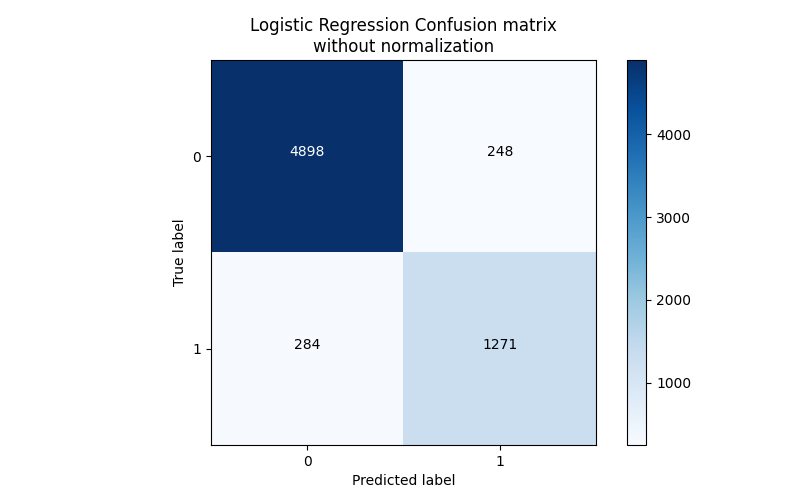

In [167]:
%matplot plt

In [168]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,5))
cmn_lr =plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Normalized Logistic Regression Confusion matrix')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Normalized confusion matrix
[[0.95180723 0.04819277]
 [0.18263666 0.81736334]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

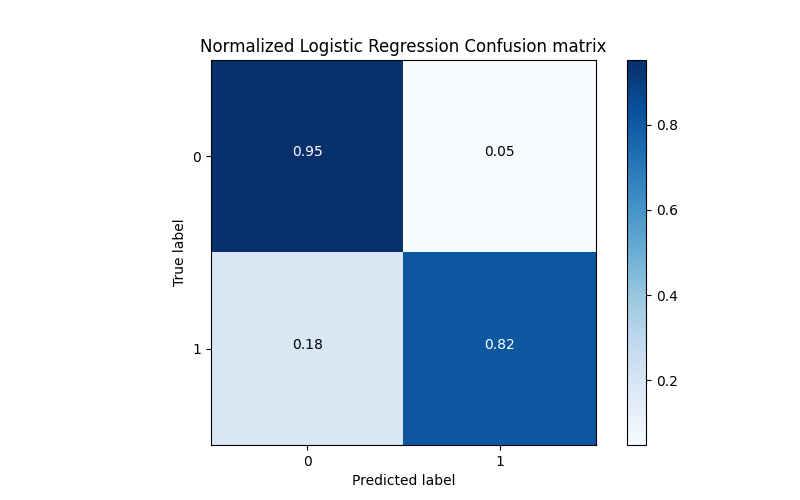

In [169]:
%matplot plt

#### Gradient-boosted Tree Tuning
 - maxDepth (Maximum depth of the tree, default=5): [5, 10]
 - minInstancesPerNode (Minimum number of instances each child must have after split, default=1): [1,3]

In [45]:
# parameter grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(model_gbt.stages[-1].maxDepth, [5, 10]) \
    .addGrid(model_gbt.stages[-1].minInstancesPerNode,[1,3]) \
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# tune the model
cvmodel_gbt, cvprediction_gbt, cvtime_gbt = model_tuning(pipeline_gbt,paramGrid_gbt,train, test)
print('Gradient-boosted Tree Model Tuning time (mins): ',cvtime_gbt)
cvacc_gbt, cvf1_gbt = evaluation(cvprediction_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-45:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3696



Gradient-boosted Tree Model Tuning time (mins):  18.77
Summary Stats
Accuracy = 0.9700044769437397
Precision = 0.9568151147098516
Recall = 0.9118971061093247
F1 Score = 0.9338162660520252

In [47]:
# training model results
cvmodel_result(cvmodel_gbt)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   maxDepth  minInstancesPerNode        f1
3        10                    3  0.930644
2        10                    1  0.925611
0         5                    1  0.925429
1         5                    3  0.925377

In [52]:
#show feature importances
feature_importance(cvmodel_gbt,cvmodel_gbt.bestModel.stages[-1].featureImportances) \
.plot(kind ='barh',x ='feature',y='importance',color ='navy',legend=None,\
      title = 'Gradient-boosted Tree Feature Importance (Full 12GB Dataset)',figsize = (8,5)).invert_yaxis();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

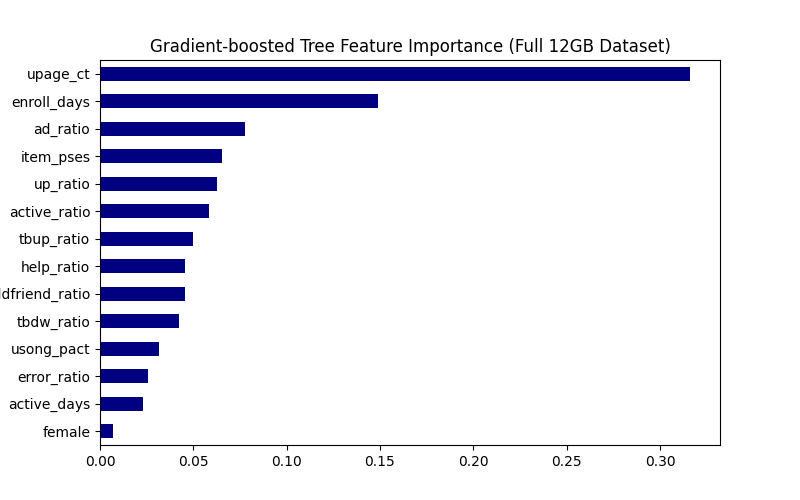

In [53]:
%matplot plt

In [135]:
#plot confusion_matrix
y_truegbt = cvprediction_gbt.select("label").withColumn("label",col("label").cast(DoubleType()))
y_truegbt = y_truegbt.toPandas()
y_predgbt = cvprediction_gbt.select("prediction")
y_predgbt = y_predgbt.toPandas()

cnf_matrix = confusion_matrix(y_truegbt, y_predgbt)
cnf_matrix

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[5082,   64],
       [ 137, 1418]])

In [156]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8,5))
cm_gbt = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Gradient-boosted Tree Confusion matrix\nwithout normalization')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Confusion matrix, without normalization
[[5082   64]
 [ 137 1418]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

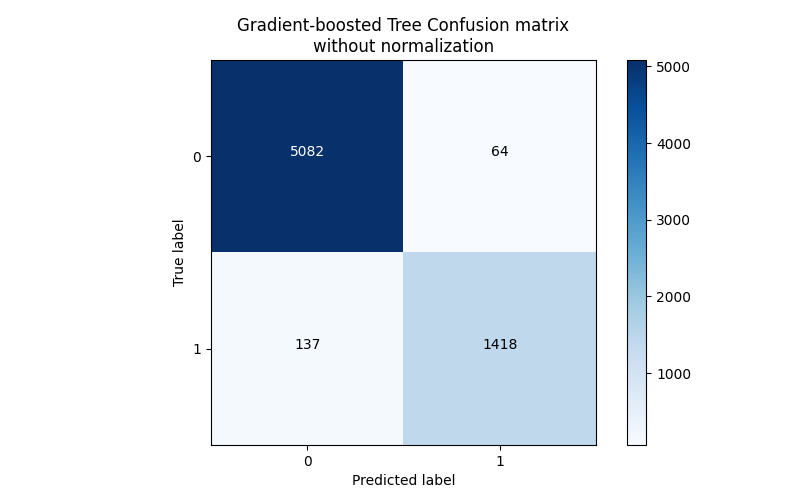

In [149]:
%matplot plt

In [163]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,5))
cmn_gbt =plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Gradient-boosted Tree Confusion matrix')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Normalized confusion matrix
[[0.98756316 0.01243684]
 [0.08810289 0.91189711]]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

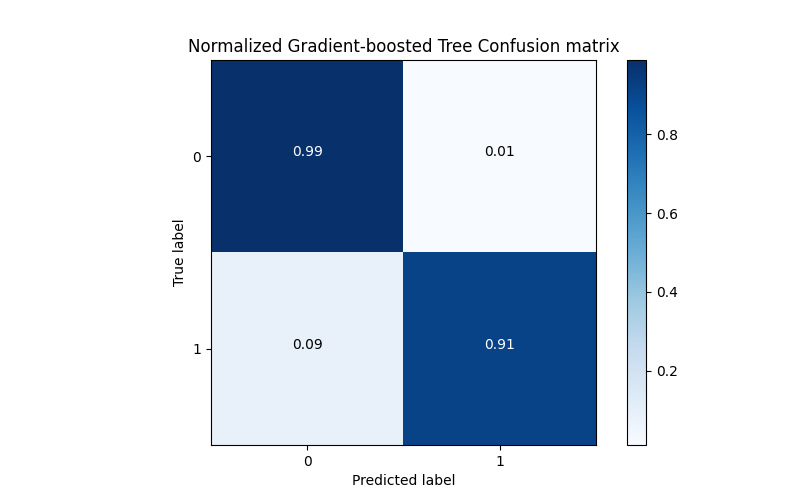

In [164]:
%matplot plt

#### Random Forest Tuning
 - minInstancesPerNode (Minimum number of instances each child must have after split, default=1): [1,3]
 - numTrees (Number of trees in the random forest, default =20):[20,30]

In [ ]:
# parameter grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(model_rf.stages[-1].minInstancesPerNode,[1,3]) \
    .addGrid(model_rf.stages[-1].numTrees, [20, 30]) \
    .build()
    
# tune the model
cvmodel_rf, cvprediction_rf, cvtime_rf = model_tuning(pipeline_rf,paramGrid_rf,train, test)
print('Random Forest Model Tuning time (mins): ',cvtime_rf)
cvacc_rf, cvf1_rf = evaluation(cvprediction_rf)    

# model results
print(cvmodel_result(cvmodel_rf))

#show feature importances
feature_importance(cvmodel_rf,cvmodel_rf.bestModel.stages[-1].featureImportances) \
.plot(kind ='bar',x ='feature',y='importance',color ='navy', \
      title = 'Random Forest Feature Importance');

#### Model Tuning Performance Summary

In [63]:
# Performance summary for Model Tuning
print('Model Tuning Performance Summary\n')
print("Logistic Regression Base Model results: F1 Score {}, Accuracy is {}".format(f1_lr, acc_lr))
print("Logistic Regression Model Tuning results: F1 Score {}, Accuracy is {}".format(cvf1_lr, cvacc_lr))
print("Gradient-boosted Tree Base Model results: F1 Score {}, Accuracy is {}".format(f1_gbt, acc_gbt))
print("Gradient-boosted Tree Model Tuning results: F1 Score {}, Accuracy is {}".format(cvf1_gbt, cvacc_gbt))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Tuning Performance Summary

Logistic Regression Base Model results: F1 Score 0.815, Accuracy is 0.92
Logistic Regression Model Tuning results: F1 Score 0.827, Accuracy is 0.921
Gradient-boosted Tree Base Model results: F1 Score 0.843, Accuracy is 0.933
Gradient-boosted Tree Model Tuning results: F1 Score 0.934, Accuracy is 0.97